# **Tutorial 1 SpatialEx Translates Histology to Omics at Single-Cell Resolution**

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpatialEx as se

device = 'cuda:6'

## 1. Prepare the dataset

### Choice 1: [Download](https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer) the Xenium Human Breast Cancer tissue dataset.

We provide H&E patch representations generated by different H&E foundation models in the following links, and the expression data is preprocessed:

**UNI (Default)**: [Slice 1](https://drive.google.com/file/d/1730OXeBG6TDQ6ejs5oRGKYhdNXbIU19i/view?usp=sharing) and [Slice 2](https://drive.google.com/file/d/17WhaKtG3iXuZuubIJEi4Y0_0z1TMKIRx/view?usp=sharing)


**CONCH**: [Slice 1](https://drive.google.com/file/d/1WmSN4EWkmj1VFKZZbwWl3oGZAa50NMRN/view?usp=drive_link) and [Slice 2](https://drive.google.com/file/d/1hrhxLl7gBVZykiqxjLc0Od9NAbzb_t_T/view?usp=drive_link)

**Gigapath**: [Slice 1](https://drive.google.com/file/d/1x-ZYl7Nda53_VXCqpHO0OloC5g2DPS0-/view?usp=drive_link) and [Slice 2](https://drive.google.com/file/d/16aypi0NFTDsYr6Yuh3vf1b7SbiqehX6c/view?usp=drive_link)

**Phikon**: [Slice 1](https://drive.google.com/file/d/1jiwdqXjQp240jN0F3XZhVW8JJZ1YQIoR/view?usp=drive_link) and [Slice 2](https://drive.google.com/file/d/1qF3XQR0C0PmYQnzeyKu68K7sngA_y2L-/view?usp=drive_link)

**ResNet50**: [Slice 1](https://drive.google.com/file/d/1aamspsRvPPcKIyApqieAspEqwFcvxgea/view?usp=drive_link) and [Slice 2](https://drive.google.com/file/d/1DwkotYbpeJKWlGFEM6enH2LC3Q4VVeRb/view?usp=drive_link)

In [ ]:
image_encoder = 'UNI'

if image_encoder == 'CONCH':
    adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_conch_resolution64_full.h5ad')
    adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_conch_resolution64_full.h5ad')
elif image_encoder == 'Gigapath':
    adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_gigapath_resolution64_full.h5ad')
    adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_gigapath_resolution64_full.h5ad')
elif image_encoder == 'Phikon':
    adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_phikon_resolution64_full.h5ad')
    adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_phikon_resolution64_full.h5ad')
elif image_encoder == 'Resnet50':
    adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_resnet50_resolution64_full.h5ad')
    adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_resnet50_resolution64_full.h5ad')
else:
    adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_uni_resolution64_full.h5ad')
    adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_uni_resolution64_full.h5ad')

### Choice 2: Preprocess your own data from scratch.
```
datasets/
│
├── Human_Breast_Cancer_Rep1/                  # The 1st slice
│   ├── cell_feature_matrix.h5                    
│   ├── cells.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif          
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv
│   ├── HBRC_Rep1_cell_coor.csv               # Cell segmentation result on H&E image
│   ├── HBRC_Rep1_Out_uni.npy
│
├── Human_Breast_Cancer_Rep2/                  # The 2nd slice
│   ├── cell_feature_matrix.h5
│   ├── cells.csv
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif        
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv
│   ├── HBRC_Rep2_cell_coor.csv
│   ├── HBRC_Rep2_Out_uni.npy
```

### 1.1 Preprocess Slice 1

In [2]:
save_root1 = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/'
save_root2 = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/'
resolution = 64
image_encoder = 'uni'

In [3]:
file_path1 = save_root1 + 'cell_feature_matrix.h5'
obs_path1 = save_root1 + 'cells.csv'
img_path1 = save_root1 + 'Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
transform_mtx_path1 = save_root1 + 'Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'
adata1 = se.pp.Read_Xenium(file_path1, obs_path1)
adata1 = se.pp.Preprocess_adata(adata1)                                              

img, scale = se.pp.Read_HE_image(img_path1)
transform_mtx = pd.read_csv(transform_mtx_path1, header=None).values
adata1 = se.pp.Register_physical_to_pixel(adata1, transform_mtx, scale=scale)
he_patches, adata1 = se.pp.Tiling_HE_patches(resolution, adata1, img)
adata1 = se.pp.Extract_HE_patches_representaion(he_patches, adata=adata1, image_encoder=image_encoder, device=device, store_key='he')

======================== Tiling HE patches for each single cells ===========================
patch radius is  32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164000/164000 [00:03<00:00, 43116.35it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2563/2563 [21:10<00:00,  2.02it/s]


### 1.2 Preprocess Slice 2

In [4]:
file_path2 = save_root2 + 'cell_feature_matrix.h5'
obs_path2 = save_root2 + 'cells.csv'
img_path2 = save_root2 + 'Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
transform_mtx_path2 = save_root2 + 'Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv'
adata2 = se.pp.Read_Xenium(file_path2, obs_path2)    
adata2 = se.pp.Preprocess_adata(adata2)

img, scale = se.pp.Read_HE_image(img_path2)
transform_mtx = pd.read_csv(transform_mtx_path2, header=None).values
adata2 = se.pp.Register_physical_to_pixel(adata2, transform_mtx, scale=scale)
he_patches, adata2 = se.pp.Tiling_HE_patches(resolution, adata2, img)
adata2 = se.pp.Extract_HE_patches_representaion(he_patches, adata=adata2, image_encoder=image_encoder, store_key='he', device=device)

======================== Tiling HE patches for each single cells ===========================
patch radius is  32
Remove the outlier cells, and Anndata file was reduced!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111555/111555 [00:01<00:00, 69620.54it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1744/1744 [14:23<00:00,  2.02it/s]


## 2. Train SpatialEx

### 2.1 Within the squencing area

In [5]:
num_neighbors = 7
epochs = 500

graph1 = se.pp.Build_hypergraph_spatial_and_HE(adata1, num_neighbors, graph_kind='spatial', return_type='crs')
graph2 = se.pp.Build_hypergraph_spatial_and_HE(adata2, num_neighbors, graph_kind='spatial', return_type='crs')

spatialex = se.SpatialEx(adata1, adata2, graph1, graph2, epochs=epochs, device=device)
spatialex.train()
panelB1, panelA2 = spatialex.auto_inference()

164000  cells are included in its nearest spot!
111555  cells are included in its nearest spot!


=================================== Start training =========================================


#Epoch: 499: train_loss: 10.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:01<00:00,  1.38it/s]


### 2.2 Outside the squencing area

In [6]:
out_spatial1 = pd.read_csv(save_root1 + '/HBRC_Rep1_cell_coor.csv', index_col=0)
out_spatial2 = pd.read_csv(save_root2 + '/HBRC_Rep2_cell_coor.csv', index_col=0)
out_he1 = np.load(save_root1 + '/HBRC_Rep1_Out_uni.npy')
out_he2 = np.load(save_root2 + '/HBRC_Rep2_Out_uni.npy')

graph1 = se.pp.Build_hypergraph(out_spatial1.values, num_neighbors=num_neighbors, normalize=True)
graph2 = se.pp.Build_hypergraph(out_spatial2.values, num_neighbors=num_neighbors, normalize=True)

panelA1_out = spatialex.inference(out_he1, graph1, panel='panelA')
panelA2_out = spatialex.inference(out_he2, graph2, panel='panelA')
panelB1_out = spatialex.inference(out_he1, graph1, panel='panelB')
panelB2_out = spatialex.inference(out_he2, graph2, panel='panelB')

## 3. Evalulation

### 3.1 Quantatitive metrics

#### 3.1.1 Training on Slice 1, test on Slice 2

In [7]:
graph = se.pp.Build_graph(adata1.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='coo')
ssim, ssim_reduce = se.utils.Compute_metrics(adata1.X.copy(), panelB1.copy(), metric='ssim', graph=graph, reduce='mean')
pcc, pcc_reduce = se.utils.Compute_metrics(adata1.X.copy(), panelB1.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata1.X.copy(), panelB1.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted gene expression on Slice 2, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)    

x shape is  164000
cell number is less than 200000
Evaluation of the predicted gene expression on Slice 2, PCC:  0.25761247  SSIM:  0.3653508153801421  CMD:  0.21490466849032452


#### 3.1.2 Training on Slice 2, test on Slice 1

In [8]:
graph = se.pp.Build_graph(adata2.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='coo')
ssim, ssim_reduce = se.utils.Compute_metrics(adata2.X.copy(), panelA2.copy(), metric='ssim', graph=graph)
pcc, pcc_reduce = se.utils.Compute_metrics(adata2.X.copy(), panelA2.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata2.X.copy(), panelA2.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted gene expression on Slice 1, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)    

x shape is  111555
cell number is less than 200000
Evaluation of the predicted gene expression on Slice 1, PCC:  0.2732997  SSIM:  0.380874110038334  CMD:  0.2032631360221221


### 3.2 Visualization

#### 3.2.1 Training on Slice 1, test on Slice 2

In [9]:
col_min, col_max = adata2.obsm['image_coor'][:, 1].min(), adata2.obsm['image_coor'][:, 1].max()
row_min, row_max = adata2.obsm['image_coor'][:, 0].min(), adata2.obsm['image_coor'][:, 0].max()
selection = (out_spatial2['image_row'] > row_min) & (out_spatial2['image_row'] < row_max) & (out_spatial2['image_col'] > col_min) & (out_spatial2['image_col'] < col_max)
obs_inner = out_spatial2[selection]
var_names = adata1.var_names

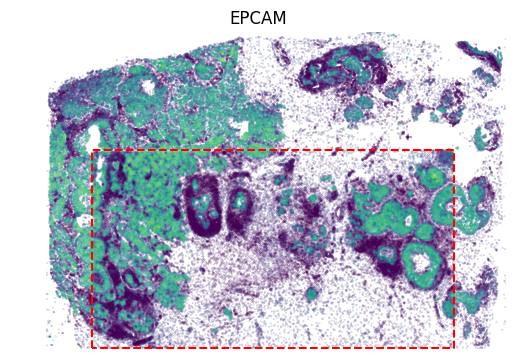

In [10]:
gene_name = 'EPCAM'
gene_idx = np.where(adata1.var_names == gene_name)[0]

value = panelA2[:, gene_idx]
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmax=vmax, s=0.01)  

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

value = panelA2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=vmax)

plt.title(gene_name)
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

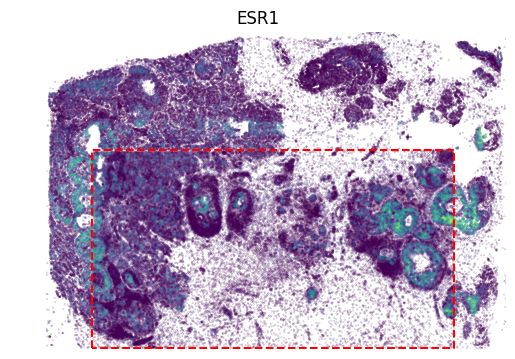

In [11]:
gene_name = 'ESR1'
gene_idx = np.where(adata1.var_names == gene_name)[0]

value = panelA2[:, gene_idx]
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmax=vmax, s=0.01)  

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

value = panelA2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=vmax)

plt.title(gene_name)
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

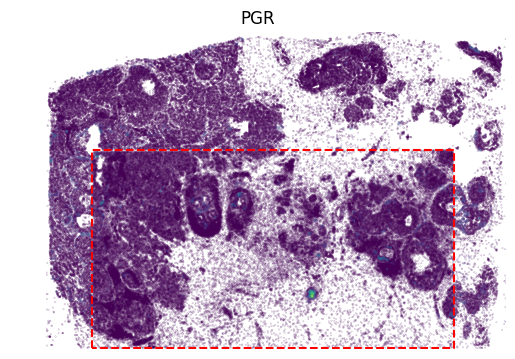

In [12]:
gene_name = 'PGR'
gene_idx = np.where(adata1.var_names == gene_name)[0]

value = panelA2[:, gene_idx]
vmax = value.max()
x, y = adata2.obsm['image_coor'][:, 0], adata2.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmin=0.05, s=0.01)  

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

value = panelA2_out[:, gene_idx]
x, y = out_spatial2['image_col'], out_spatial2['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=vmax)

plt.title(gene_name)
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.show()